<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/Unnamed_Fitabase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install glob2

In [ ]:
from glob import glob
import os
import pandas as pd

path = "/content/drive/MyDrive/Iqram Sir/history/Fitabase data pulls - seperate"

#path = "/content/drive/MyDrive/Cornell/MADE Lab/Wearable Project/Data/Fitbit/Fitabase data pulls - seperate"


#Function

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

def get_content(patient_folder_adrs):

  post_adrs = sorted(glob(patient_folder_adrs+"/*"))[0]


  pre_adrs = sorted(glob(patient_folder_adrs+"/*"))[1]

  for i in glob(post_adrs+"/*"):
    content = i.split("_")
    if "1min" in content:
      post_1min = i
    if "minuteCaloriesNarrow" in content:
      post_cal = i
    if "minuteMETsNarrow" in content:
      post_met = i


  for i in glob(pre_adrs+"/*"):
    content = i.split("_")
    if "1min" in i.split("_"):
      pre_1min = i
    if "minuteCaloriesNarrow" in content:
      pre_cal = i
    if "minuteMETsNarrow" in content:
      pre_met = i

  return post_1min, post_cal,post_met, pre_1min, pre_cal, pre_met




def plot(X,Y,m,c,hr_aee = False):
  fig = plt.figure(figsize=(13,8))
  ax = fig.add_subplot()
  fig.subplots_adjust(top=0.85)

  # Set titles for the figure and the subplot respectively
  #fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
  if hr_aee == True:
    ax.set_title('Max HR & aEE',fontweight='bold')
  else:
    ax.set_title('Max HR',fontweight='bold')

  ax.scatter(X, Y)

  high_y = Y.max()

  high_x = (high_y-c)/m

  rang_y=[Y.min(),high_y]

  ax.plot((rang_y-c)/m, rang_y, color = "red")

  ax.scatter(high_x, high_y, color='green')
  ax.annotate('(aEEMax,HRMax)', xy=(high_x, high_y), xytext=(high_x-5, high_y+10),fontweight='bold')
  ax.annotate("("+str(round(high_x[0],2))+","+str(high_y)+")", xy=(high_x, high_y), xytext=(high_x-3, high_y+5),fontweight='bold',color = 'purple')


  if hr_aee == True:
    ax.set_xlabel("aEE_MAX(J/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR_MAX(BPM)",fontweight='bold',fontsize=12)
  else:
    ax.set_xlabel("aEE(J/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR(BPM)",fontweight='bold',fontsize=12)

  ax.axis([0, high_x+10, 0, high_y+30])

  ax.grid()
  plt.show()




def engine(df_1min, df_cal,df_met,hr_aee = False):
  list_1 = list(df_1min["Time"])
  list_2 = list(df_cal["ActivityMinute"])
  list_3 = list(df_met["ActivityMinute"])


  hr = []
  aee = []
  time = []
  mets = []

  if len(list_1)>len(list_2):
    for i in tqdm(list_1):
      if i in list_2 and i in list_3:
        if list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0]>15:
          hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
          aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
          mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
          time.append(i)

  else:
    for i in tqdm(list_2):
      if i in list_1 and i in list_3:
        if list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0]>15:
          hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
          aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
          mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
          time.append(i)

  d={
    "Time" : time,
     "HR(BPM)" : hr,
     "aEE(J/min)":aee,
     "METs" : mets
  }

  dataFrame = pd.DataFrame.from_dict(d)


  Y = dataFrame["HR(BPM)"].values.reshape(-1, 1)
  X = dataFrame["aEE(J/min)"].values.reshape(-1, 1)
  reg = LinearRegression().fit(X, Y)
  m = reg.coef_[0]
  c = reg.intercept_

  if hr_aee == True:
    hr_mx = Y.max()
    aee_mx = (hr_mx-c)/m
    return hr_mx, round(aee_mx[0],2),m[0],c[0]

  else:
    plot(X,Y,m,c)
    return dataFrame



def test_signle_sample(data,df_1min,df_cal,df_met):
  total_row = data.shape[0]
  print("Total DataRow: ",total_row)

  err_row=[]

  for i in tqdm(range(total_row)):
    print(data["Time"][i], data['HR(BPM)'][i],round(data['aEE(J/min)'][i],2),data['METs'][i])

    hr = list(df_1min.query("Time == '"+data["Time"][i]+"'")['Value'])[0]
    cal = round(list(df_cal.query("ActivityMinute == '"+data["Time"][i]+"'")['Calories'])[0],2)
    mets = list(df_met.query("ActivityMinute == '"+data["Time"][i]+"'")['METs'])[0]
    print(hr,round(cal*4.184,2),mets)
    print("------------------------------------------------------------")

    if hr != data['HR(BPM)'][i] or cal != round(data['aEE(J/min)'][i]/4.184,2) or mets != data['METs'][i]:
      err_row.append((data["Time"][i],i))
  return err_row


#Sample Test for single subject

In [ ]:
subject = '018-PDT'

In [ ]:


for i in sorted(glob(path+"/*")):
  #get_contenct(i)
  if subject in i.split("/"):
    Post_1min,Post_cal,Post_met, Pre_1min,Pre_cal,Pre_met = get_content(i)

df_post_1min = pd.read_csv(Post_1min)
df_post_cal = pd.read_csv(Post_cal)
df_post_met = pd.read_csv(Post_met)

df_pre_1min = pd.read_csv(Pre_1min)
df_pre_cal = pd.read_csv(Pre_cal)
df_pre_met = pd.read_csv(Pre_met)


##Post Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `post condition`.<br>


  0%|          | 0/51840 [00:00<?, ?it/s]

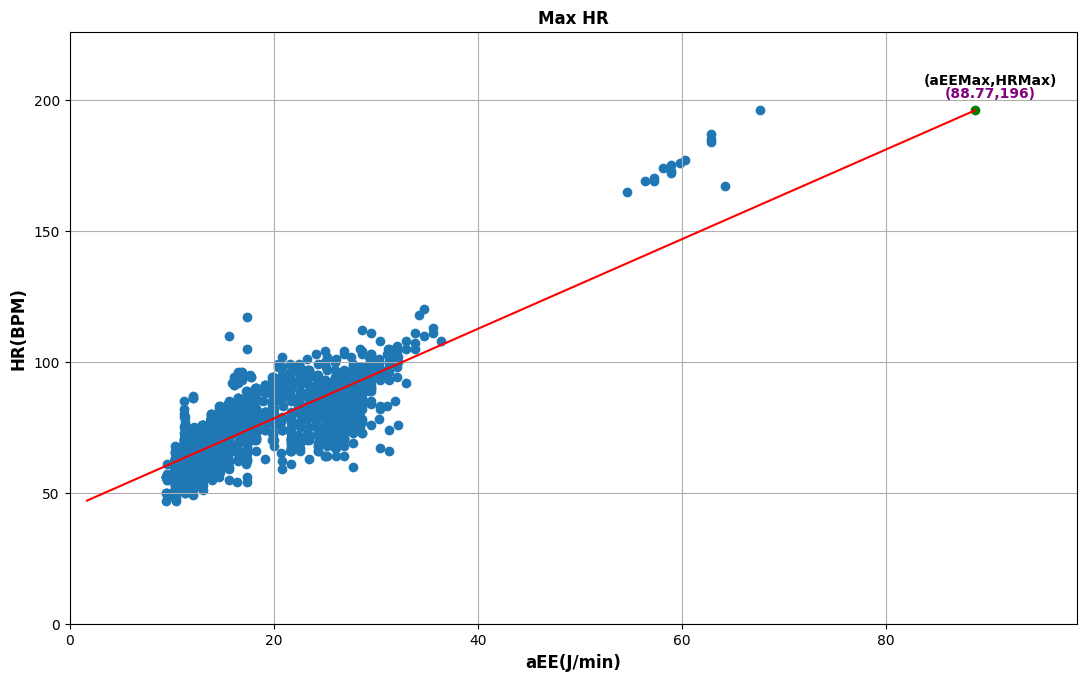

In [ ]:
data = engine(df_post_1min,df_post_cal,df_post_met)

In [ ]:
#print(len(test_signle_sample(data, df_post_1min, df_post_cal, df_post_met)))

##Pre Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `pre condition`.<br>

  0%|          | 0/15840 [00:00<?, ?it/s]

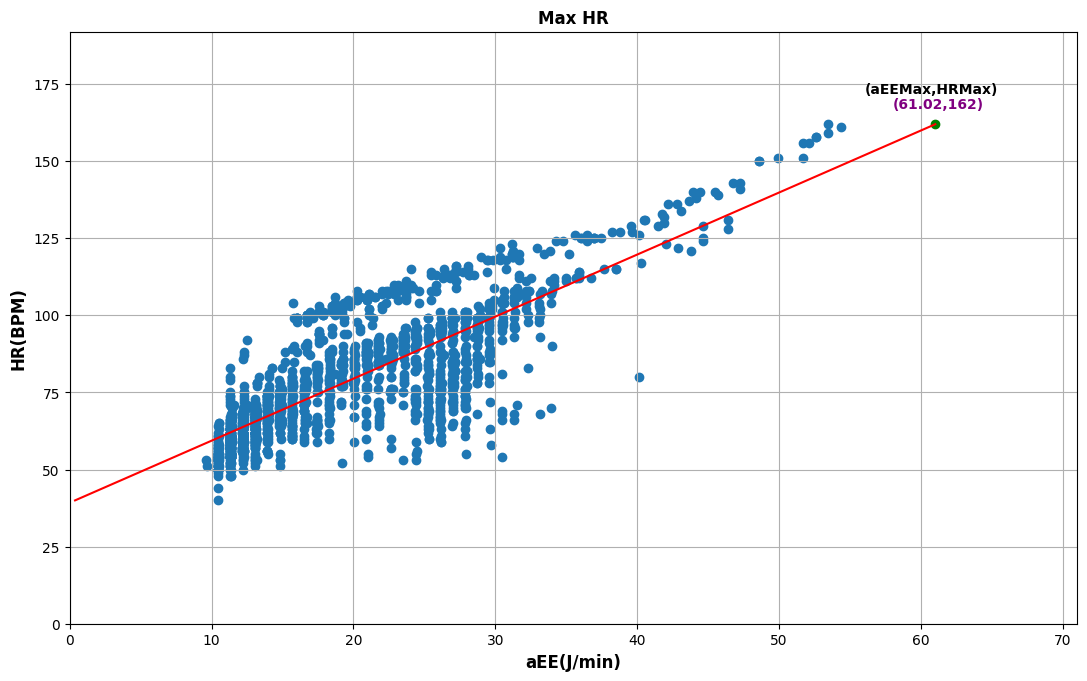

In [ ]:
data = engine(df_pre_1min,df_pre_cal,df_pre_met)

###Testing

In [ ]:
#print(len(test_signle_sample(data, df_pre_1min, df_pre_cal, df_pre_met)))

#Dataset Creation with all `HR_MAX` and `aEE_MAX` values of all patients.

In [ ]:
from tqdm.notebook import tqdm
p_id = []
condition = []
hr_max = []
aee_max = []
slope = []
intercept = []



for i in tqdm(sorted(glob(path+"/*"))):

  print()
  print()
  sub =  os.path.basename(i)
  print("Subject processing: ",sub)
  Post_1min, Post_cal,Post_met, Pre_1min, Pre_cal,Pre_met = get_content(i)

  p_id.append(sub)
  condition.append('pre')
  df_pre_1min = pd.read_csv(Pre_1min)
  df_pre_cal = pd.read_csv(Pre_cal)
  df_pre_met = pd.read_csv(Pre_met)
  print("Pre Condition In Process:")
  h,a,m,c = engine(df_pre_1min,df_pre_cal,df_pre_met,True)
  hr_max.append(h)
  aee_max.append(a)
  slope.append(m)
  intercept.append(c)
  print("Pre Condition Process Complete...")

  p_id.append(sub)
  condition.append('post')
  df_post_1min = pd.read_csv(Post_1min)
  df_post_cal = pd.read_csv(Post_cal)
  df_post_met = pd.read_csv(Post_met)
  print("Post Condition In Process:")
  h,a,m,c = engine(df_post_1min,df_post_cal,df_post_met,True)
  hr_max.append(h)
  aee_max.append(a)
  slope.append(m)
  intercept.append(c)
  print("Post Condition Process Complete...")
  print()

  print("Processing Complete.....")
  print("------------------------------------------------------------------------")


print("Dataset creation complete......")

  0%|          | 0/36 [00:00<?, ?it/s]



Subject processing:  001-JV
Pre Condition In Process:


  0%|          | 0/80640 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/50400 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  002-JR
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/41760 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  003-ES
Pre Condition In Process:


  0%|          | 0/14400 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  004-LY
Pre Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/43200 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  005-DF
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/47075 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  006-MK
Pre Condition In Process:


  0%|          | 0/21600 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  007-DD
Pre Condition In Process:


  0%|          | 0/12960 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  008-KL
Pre Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  010-ML
Pre Condition In Process:


  0%|          | 0/41760 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/46827 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  011-CR
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  012-DP
Pre Condition In Process:


  0%|          | 0/11520 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/53280 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  013-MB
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/53280 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  014-WK
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  015-BL
Pre Condition In Process:


  0%|          | 0/17280 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  016-JN
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  018-PDT
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/51840 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  019-CM
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/43200 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  020-GB
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/43200 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  021-GDB
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/47520 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  022-ND
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/45200 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  023-FG
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/49661 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  024-DP
Pre Condition In Process:


  0%|          | 0/18720 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/49655 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  025-IP
Pre Condition In Process:


  0%|          | 0/23040 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/55367 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  026-LW
Pre Condition In Process:


  0%|          | 0/24480 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/46080 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  027-SR
Pre Condition In Process:


  0%|          | 0/18720 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/45628 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  028-JR
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/48206 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  029-RR
Pre Condition In Process:


  0%|          | 0/17280 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/44037 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  031-SG
Pre Condition In Process:


  0%|          | 0/45252 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/43200 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  032-SS
Pre Condition In Process:


  0%|          | 0/58263 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  033-PJ
Pre Condition In Process:


  0%|          | 0/18720 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/4354 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  034-DS
Pre Condition In Process:


  0%|          | 0/20160 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/43888 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  035-DP
Pre Condition In Process:


  0%|          | 0/37440 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/15380 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  036-RD
Pre Condition In Process:


  0%|          | 0/15840 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/55892 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  037-JB
Pre Condition In Process:


  0%|          | 0/28800 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/52535 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  038-JS
Pre Condition In Process:


  0%|          | 0/12960 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/7576 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------


Subject processing:  039-NS
Pre Condition In Process:


  0%|          | 0/11520 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/14489 [00:00<?, ?it/s]

Post Condition Process Complete...

Processing Complete.....
------------------------------------------------------------------------
Dataset creation complete......


In [ ]:
main_dict = {
    "Patient_Id" : p_id,
    "Condition" : condition,
    "HR_MAX(BPM)" : hr_max,
    "aEE_MAX(J/min)": aee_max,
    "slope_HR/Calories":slope,
    "Intercept_HR/Calories":intercept
}


df = pd.DataFrame.from_dict(main_dict)
df

In [ ]:
file_save_destination = '/content/drive/MyDrive/Cornell/MADE Lab/Wearable Project/Data/Colab Data/Regression Results/Fitabase_HR_aEE_MAX_MET15_08.29.2023.csv'
df.to_csv(file_save_destination,index=False)